In [105]:
import re
import time
import html
from selenium import webdriver
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import nltk
from nltk.corpus import stopwords
import warnings
from PIL import Image
import numpy as np

In [106]:
warnings.filterwarnings('ignore')

In [107]:
# БЫСТРЫЙ ПАРСЕР
start = time.time()
url = "https://www.imdb.com/title/tt8579674/reviews"

# Создаем экземпляр браузера
driver = webdriver.Chrome()

# Открываем страницу
driver.get(url)

# Ждем некоторое время, чтобы страница успела загрузиться
time.sleep(2)

# Проскроллим страницу до тех пор, пока кнопка "Load More" не исчезнет
while True:
    try:
        load_more_button = driver.find_element(By.ID, "load-more-trigger")
        if load_more_button.is_displayed():
            load_more_button.click()
            # Ждем некоторое время, чтобы загрузились дополнительные отзывы
            time.sleep(2)
        else:
            break
    except:
        break

# Парсим полную страницу
soup = BeautifulSoup(driver.page_source, "html.parser")
review_containers = soup.find_all("div", class_="review-container")

reviews = {}  # Словарь для хранения уникальных отзывов

for review_container in review_containers:
    review_id = review_container.find("a", class_="title")["href"]  # Идентификатор отзыва

    # Проверка на уникальность отзыва по его идентификатору
    if review_id not in reviews:
        title = review_container.find("a", class_="title").text.strip()
        display_name = review_container.find("span", class_="display-name-link").text.strip()
        review_date = review_container.find("span", class_="review-date").text.strip()
        
        # Попробуйте извлечь текст отзыва внутри контейнера отзыва
        try:
            review_text = review_container.find("div", class_="text show-more__control").get_text(strip=True)
        except AttributeError:
            review_text = review_container.find("div", class_="text show-more__control clickable").get_text(strip=True)
        # Найти элемент с классом "rating-other-user-rating"
        rating_element = review_container.find("span", class_="rating-other-user-rating")

        if rating_element:
            # Извлечь текст из элемента
            rating_text = rating_element.get_text(strip=True)

            # Разбить текст на части, используя "/"
            parts = rating_text.split('/')

            # Проверить, что получилось две части
            if len(parts) == 2:
                rating_value = parts[0].strip()
                # Преобразовать значение оценки в число
                rating = int(rating_value)
                reviews[review_id] = {
                    "Заголовок отзыва": title,
                    "Имя пользователя": display_name,
                    "Дата отзыва": review_date,
                    "Оценка": rating,
                    "Текст отзыва": review_text
                }
            else:
                rating = None
        else:
            rating = None

# Закрываем браузер
driver.quit()

# Преобразование словаря в список
unique_reviews = list(reviews.values())
print(f"Количество отзывов: {len(unique_reviews)}")
print(f"Время выполнения: {time.time() - start} секунд")

Количество отзывов: 3386
Время выполнения: 348.9623384475708 секунд


In [108]:
unique_reviews

[{'Заголовок отзыва': '"He travels the fastest who travels alone"',
  'Имя пользователя': 'TheLittleSongbird',
  'Дата отзыва': '13 April 2021',
  'Оценка': 10,
  'Текст отзыва': "There are some great WW1 films out there, the granddaddy of them all in my view being 1930's 'All Quiet on the Western Front'. Also appreciate many of the actors here, though they are in cameo roles, and Sam Mendes as a director (of the films of his seen, almost all, 'Spectre' is the only one to not do much for me). Roger Deakins and Thomas Newman are masters in their field, Deakins is one of the best cinematographers in the business and Newman's score for 'Road to Perdition' is a favourite.'1917' was seen for all those reasons. As well as because of the critical acclaim, with it being considered as one of 2019's year's best films. After seeing it, my thoughts are that the acclaim for '1917' is richly deserved in one of the best and most powerful films that year. It did connect a lot with me, due to watching 

#### Структура отзывов сайта:

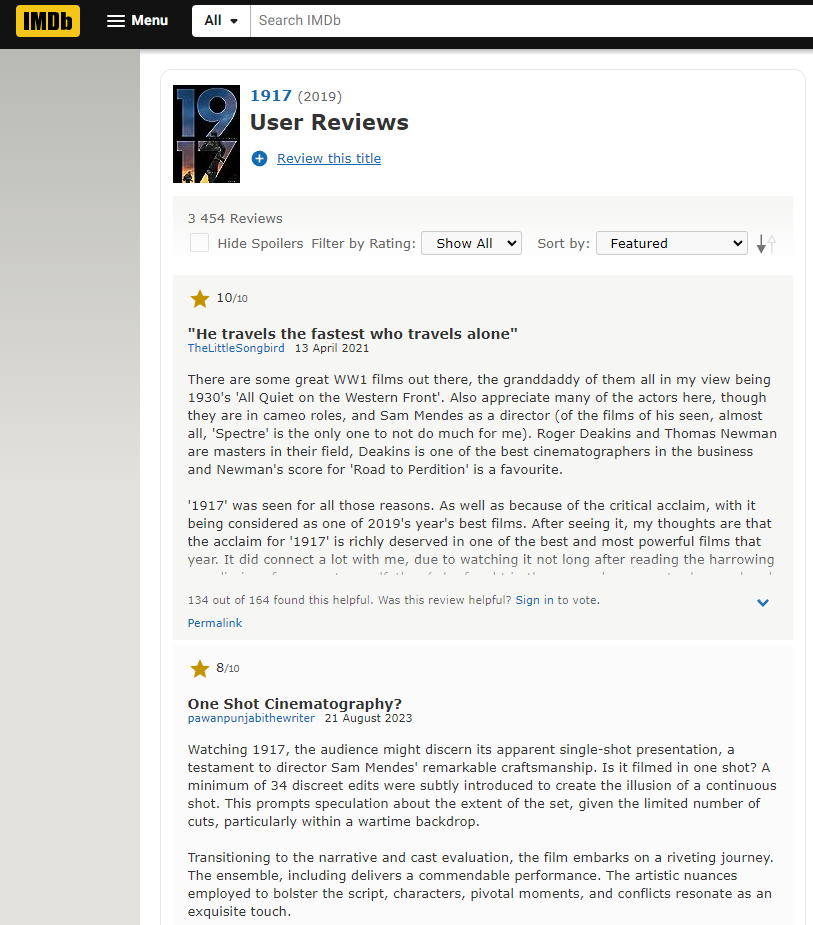

Было обработано 3454 отзыва, из которых 69 не имели оценку. Таким образом, была проведена очистка и они не были включены в конечный датасет отзывов. Каждый отзыв имеет 5 полей: Имя пользователя, Дата отзыва, Заголовок отзыва, Оценка (от 1 до 10) и Текст отзыва.

In [109]:
df = pd.DataFrame(unique_reviews)
date_format = '%d %B %Y'
df['Дата отзыва'] = pd.to_datetime(df['Дата отзыва'], format=date_format)
print("Описательная статистика рейтингов:")
print(df["Оценка"].describe())

print(f"Средняя оценка: {df['Оценка'].mean()}")
print(f"Медианная оценка: {df['Оценка'].median()}")

print(f"Минимальная оценка: {df['Оценка'].min()}")
print(f"Максимальная оценка: {df['Оценка'].max()}")


Описательная статистика рейтингов:
count    3386.000000
mean        7.660957
std         2.571792
min         1.000000
25%         6.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: Оценка, dtype: float64
Средняя оценка: 7.660956881275841
Медианная оценка: 9.0
Минимальная оценка: 1
Максимальная оценка: 10


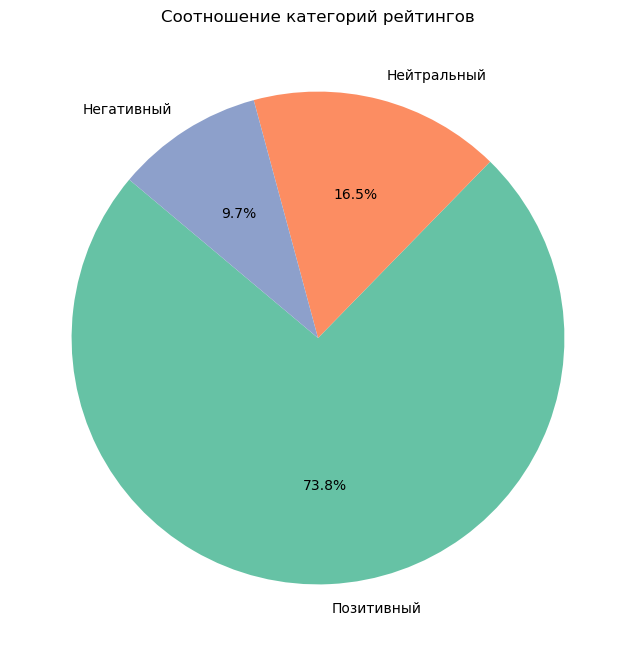

In [110]:
def classify_rating(rating):
    if rating >= 7:
        return "Позитивный"
    elif rating >= 4:
        return "Нейтральный"
    else:
        return "Негативный"

df['Категория рейтинга'] = df['Оценка'].apply(classify_rating)

rating_counts = df['Категория рейтинга'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Соотношение категорий рейтингов')
plt.show()


Большинство отзывов позитивные (почти 74%). Негативных отзывов минимальное количество (менее 10%), нейтральных отзывов 16.5% (то есть 1/6 часть от всех отзывов)

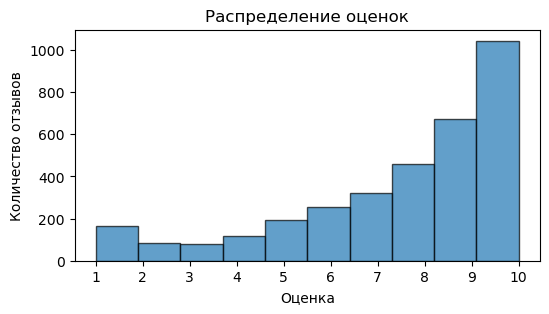

In [111]:
plt.figure(figsize=(6, 3))
plt.hist(df["Оценка"], bins=10, align='mid', edgecolor='k', alpha=0.7)
plt.xlabel("Оценка")
plt.ylabel("Количество отзывов")
plt.title("Распределение оценок")
plt.xticks(list(range(1, 11)))
plt.show()

Из графика видно, что самой популярной оценкой является оценка 10 (около 1000 отзывов), также около 700 пользователей оценили фильм на 9. Далее идет плавный спуск - чем меньше оценка, тем меньше количество таких отзывов. Таким образом, видна довольно сильная несбалансированность в данных. Далее будет применены `random oversampling` и `random undersampling` для перебалансировки классов с целью улучшить данные для обучения модели

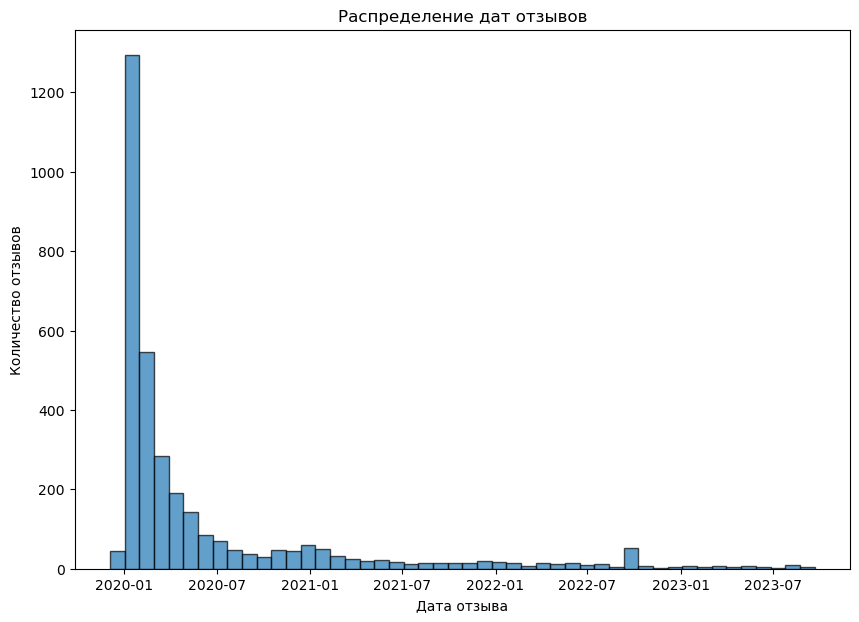

In [112]:
plt.figure(figsize=(10, 7))
plt.hist(df["Дата отзыва"], bins=48, edgecolor='k', alpha=0.7)
plt.xlabel("Дата отзыва")
plt.ylabel("Количество отзывов")
plt.title("Распределение дат отзывов")
plt.show()

Из распределения видно, что большинство отзывов (более 2000) были оставлены в январе? феврале и марте
2020 года, в первые месяцы после выхода фильма в мировой прокат. Также многократное повышение количества отзывов относительно соседних месяцев наблюдается в сентябре 2022 года.

## Формирование облака слов

При формировании облака слов убраны стоп слова, а также слова "movie" и "film" так как они являются крайне популярными в отзывах, занимают очень много места при визуализации и не имеют смысловой нагрузки.

In [113]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Drama\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

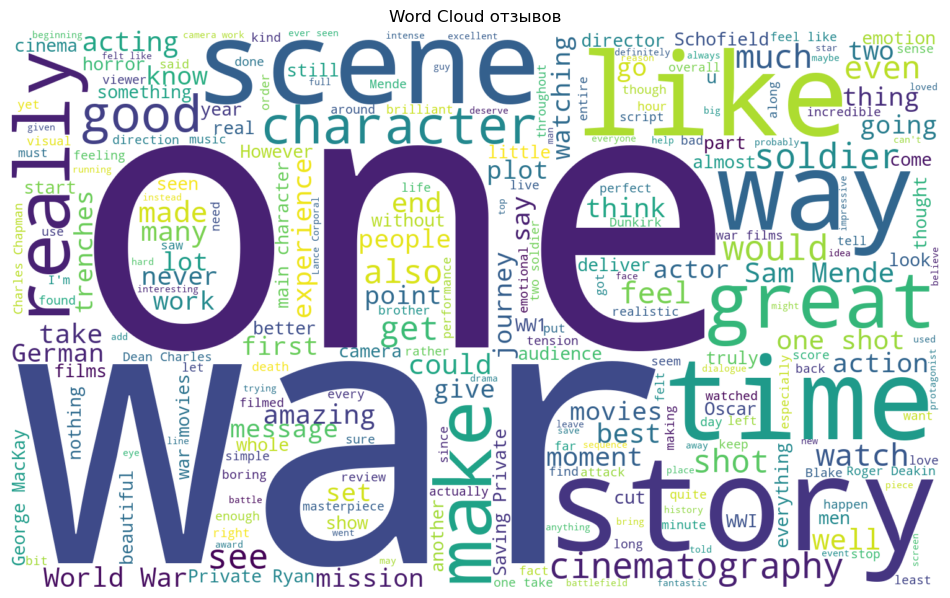

In [114]:
stop_words = set(stopwords.words('english'))
stop_words.add('movie')
stop_words.add('film')
all_reviews_text = ' '.join(df['Текст отзыва'])

wordcloud = WordCloud(width=1500, height=900, background_color='white', stopwords=stop_words, collocations=True, max_words=250).generate(all_reviews_text)


plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud отзывов')
plt.show()

Так как рассматриваемый фильм является военным, ождаемо, самым популярным словом в отзывах является war. Кроме того, популярными словами являются story, scene и plot, что говорит о качественном сценарии и постановке. Также пользователи часто отмечают персонажей и актеров. Также довольно крупным является словосочетание "one shot", "camera" и "cut", что говорит о том, что пользователи часто отмечают операторскую работу и тот факт, что фильм снят одним кадром и все склейки кадров замаскированы.

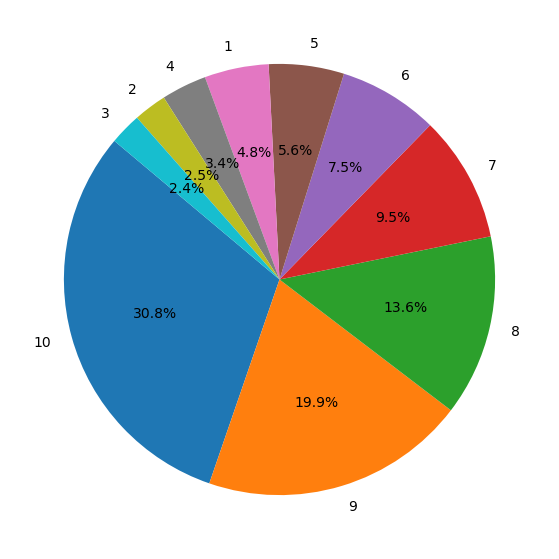

In [115]:
plt.figure(figsize=(10,7))
plt.pie(df['Оценка'].value_counts(), autopct='%1.1f%%', startangle=140, labels=df['Оценка'].value_counts().index)
plt.show()

Из диаграммы видно, что наблюдается явная разбалансировка классов, поэтому применим Undersampling и Oversampling.

In [116]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Обучение с применением Undersampling и Oversampling.

In [131]:
df['Text'] = df['Заголовок отзыва'] + ' ' + df['Текст отзыва']

# Преобразование текста в числовой формат (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X = tfidf_vectorizer.fit_transform(df['Text'])
y = df['Оценка']

# Используем RandomOverSampler для увеличения представленности классов
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

# Используем RandomUnderSampler для уменьшения представленности классов
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42)

In [132]:
# Модель с использованием SVM
start_time = time.time()
svm_model = SVC()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time
start_time = time.time()
y_pred_svm = svm_model.predict(X_test)
test_time = time.time() - start_time
accuracy_svm = svm_model.score(X_test, y_test)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.99      0.99       169
           2       1.00      1.00      1.00       152
           3       1.00      1.00      1.00       172
           4       1.00      1.00      1.00       172
           5       1.00      0.98      0.99       143
           6       0.99      0.97      0.98       166
           7       0.92      0.93      0.93       147
           8       0.89      0.83      0.86       151
           9       0.70      0.68      0.69       155
          10       0.66      0.74      0.70       139

    accuracy                           0.92      1566
   macro avg       0.91      0.91      0.91      1566
weighted avg       0.92      0.92      0.92      1566



In [133]:
# Модель с использованием Случайного леса (Random Forest)
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
training_time_rf = time.time() - start_time
start_time = time.time()
y_pred_rf = rf_model.predict(X_test)
test_time_rf = time.time() - start_time
accuracy_rf = rf_model.score(X_test, y_test)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       169
           2       1.00      1.00      1.00       152
           3       1.00      1.00      1.00       172
           4       0.99      1.00      0.99       172
           5       1.00      0.98      0.99       143
           6       0.99      0.97      0.98       166
           7       0.97      0.94      0.96       147
           8       0.90      0.82      0.86       151
           9       0.73      0.65      0.68       155
          10       0.63      0.81      0.71       139

    accuracy                           0.92      1566
   macro avg       0.92      0.92      0.92      1566
weighted avg       0.92      0.92      0.92      1566



In [134]:
# Модель с использованием Наивного Байесовского классификатора (Multinomial Naive Bayes)
start_time = time.time()
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
training_time_nb = time.time() - start_time
start_time = time.time()
y_pred_nb = nb_model.predict(X_test)
test_time_nb = time.time() - start_time
accuracy_nb = nb_model.score(X_test, y_test)
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.91      0.92       169
           2       0.95      1.00      0.97       152
           3       0.96      0.95      0.96       172
           4       0.93      0.97      0.95       172
           5       0.87      0.90      0.89       143
           6       0.86      0.77      0.81       166
           7       0.79      0.73      0.76       147
           8       0.55      0.76      0.64       151
           9       0.62      0.49      0.55       155
          10       0.62      0.58      0.59       139

    accuracy                           0.81      1566
   macro avg       0.81      0.81      0.80      1566
weighted avg       0.82      0.81      0.81      1566



In [135]:
# Модель с использованием Градиентного бустинга (Gradient Boosting)
start_time = time.time()
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
training_time_gb = time.time() - start_time
start_time = time.time()
y_pred_gb = gb_model.predict(X_test)
test_time_gb = time.time() - start_time
accuracy_gb = gb_model.score(X_test, y_test)
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.95      0.93       169
           2       0.94      0.95      0.95       152
           3       0.99      0.99      0.99       172
           4       0.93      0.98      0.96       172
           5       0.90      0.85      0.88       143
           6       0.87      0.79      0.83       166
           7       0.74      0.77      0.76       147
           8       0.65      0.68      0.66       151
           9       0.62      0.61      0.61       155
          10       0.57      0.55      0.56       139

    accuracy                           0.82      1566
   macro avg       0.81      0.81      0.81      1566
weighted avg       0.82      0.82      0.82      1566



## Общие выводы по всем моделям:
У всех четырех моделей примерно сопоставимые по качеству предсказания. Видно, что наиболее удачные оценки для предсказания во всех моделях это оценки 2, 3, 4, 5. Это можно объяснить тем, что в изначальной выборке отзывов с данными оценками было мало и нужно было использовать Underesampling и Oversampling. Это приводит к тому, что как в трейновой так и в тестовой выборке есть некоторое количество одинаковых отзывов, что и способствует улучшению оценки (что на самом деле не является полноценным показателем эффективности, ведь модель по сути училась на каком то количестве повторяющихся отзывов). В целом по метрикам результат довольно высокий, лучший у метода опорных векторов и случайного леса.

In [141]:
results = pd.DataFrame({
    'Model': ['SVM', 'Random Forest', 'Naive Bayes', 'Gradient Boosting'],
    'Run time': [training_time+test_time, training_time_rf+test_time_rf, training_time_nb+test_time_nb, training_time_gb+test_time_gb], 
    'Training time': [training_time, training_time_rf, training_time_nb, training_time_gb],
    'Test time': [test_time, test_time_rf, test_time_nb, test_time_gb],
    'Accuracy': [accuracy_svm, accuracy_rf, accuracy_nb, accuracy_gb]
})
print("Матрица результатов:")
print()
print(results.to_string(index=False))

Матрица результатов:

            Model   Run time  Training time  Test time  Accuracy
              SVM  41.495626      36.738820   4.756806  0.916347
    Random Forest  11.397548      11.306560   0.090989  0.919540
      Naive Bayes   0.018931       0.018931   0.000000  0.810983
Gradient Boosting 181.443471     181.417784   0.025686  0.820562


## Выводы по каждой модели:
Самая высокая точность у модели Random Forest, а сразу за ней с минимальной разницей идет метод опорных векторов с результатами 0.92 и 0.916 соответсвтенно. Далее идет градиентный бустинг и наивный Байесовский классификатор с результатами 0.82 и 0.81 соответсвтенно. Самое быстрое время выполнения у навиного байесовского классификатора - более чем в 1000 раз быстрее чем у ближайшего по быстроте метода, соотвественно, при необходимости достижения масимальной скорости данный метод - лучший вариант. Самый долгий метод - градиентный бустинг - в 10000 раз медленнее, чем самый быстрый метод. В общем, наилучшие результаты по совокупности показателей (скорость выполнения и результат) у метода Random Forest - наивысшая точность и довольно маленькое время выполнения.

### Доп. задание:
Ввести заголовок и текст отзыва, а модель Random Forest предсказывает значение.

In [137]:
from translate import Translator
translator = Translator(to_lang="en")  # "en" означает английский язык

In [139]:
# Ввод текста от пользователя
title = input("Введите заголовок отзыва: ")
text = input("Введите текст отзыва: ")

translated_title = translator.translate(title)
translated_text = translator.translate(text)

text = translated_text + ' ' + translated_title  # Объединяем заголовок и текст отзыва
text_vectorized = tfidf_vectorizer.transform([text])  # Векторизуем текст
predicted_rating = rf_model.predict(text_vectorized)[0]  # Предсказываем оценку

print(f"Предсказанная оценка: {predicted_rating}")

Введите заголовок отзыва: Хороший фильм с потрясающей операторской работой
Введите текст отзыва:  1917 - безусловно хороший фильм. Операторская работа и постановка заслуживают отдельного внимания! Единственное, что в этом фильме не на идеальном уровне во многих моментах - актерская игра. Актеры в нескольких сценах ведут себя крайне нереалистично и не в соответствии с временем действий в фильме. Кроме того в фильме есть несколько киноляпов, которых конечно же не должно быть в картине такого уровня
Предсказанная оценка: 10


Видим, что модель верно определила тональность отзыва, но для данного отзыва оценка 10 выглядит преувеличением. Спарведливой была бы оценка 8-9